# Plot maps using shapefiles

In this notebook we will load shapefiles and prepare data frame with longitude and latitude informaction.\
We will also plot some maps using data from shapefiles.

`shapefile` package will be used.

Shapefiles required for this notebook can be found here: [NYC](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).\
More info about package can be found here: [shapefiles](https://pypi.org/project/pyshp/#reading-shapefiles).\
**Note!** This notebook was created on the basis of [Mapping Geograph Data in Python](https://towardsdatascience.com/mapping-geograph-data-in-python-610a963d2d7f).

In [16]:
import shapefile
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [17]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)

### Loading data and creating a shapefile reader

Let's load data and create a `Reader`.

In [18]:
shape_file_path = 'data/taxi_zones/taxi_zones.shp'

In [19]:
sf = shapefile.Reader(shape_file_path)

We can found out how many shapes we have.

In [20]:
len(sf.shapes())

263

Let's look at one row of our data.

In [21]:
sf.records()[0]

Record #0: [1, 0.116357453189, 0.0007823067885, 'Newark Airport', 1, 'EWR']

In [22]:
sf.records()[102:105]

[Record #102: [103, 0.0143055167343, 6.33056361314e-06, "Governor's Island/Ellis Island/Liberty Island", 103, 'Manhattan'],
 Record #103: [104, 0.0212208330928, 1.19205339715e-05, "Governor's Island/Ellis Island/Liberty Island", 103, 'Manhattan'],
 Record #104: [105, 0.0774253398314, 0.000368636392805, "Governor's Island/Ellis Island/Liberty Island", 103, 'Manhattan']]

### Convert shapefile into data frame

In [23]:
def read_shapefile(sf):
    """
    Read a shapefile into a pandas dataframe with a 'coords' 
    column holding the geometry information.
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]    
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)    
    return df

In [24]:
df = read_shapefile(sf)

In [25]:
df.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,coords
0,1,0.116357,0.000782,Newark Airport,1,EWR,"[(933100.9183527103, 192536.08569720192), (933..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"[(1033269.2435912937, 172126.0078125), (103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"[(1026308.7695066631, 256767.6975403726), (102..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"[(992073.4667968601, 203714.07598876953), (992..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"[(935843.3104932606, 144283.33585065603), (936..."


In the last column we can see coordinates. These are all the points that creates each zone.
We will use them to calculate center for each zone.

In [27]:
def center_of_a_shape(sf, shape_id):
    """ Calculate center point of a given shape (zone) """
    shape = sf.shape(shape_id)
    x = [s[0] for s in shape.points]
    y = [s[1] for s in shape.points]
    
    return np.mean(x), np.mean(y)

In [28]:
df['x'] = pd.Series(df.index).apply(lambda x: center_of_a_shape(sf, x)[0])
df['y'] = pd.Series(df.index).apply(lambda x: center_of_a_shape(sf, x)[1])

In [29]:
df.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,coords,x,y
0,1,0.116357,0.000782,Newark Airport,1,EWR,"[(933100.9183527103, 192536.08569720192), (933...",9.359210e+05,190798.948561
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"[(1033269.2435912937, 172126.0078125), (103343...",1.034880e+06,162357.340842
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"[(1026308.7695066631, 256767.6975403726), (102...",1.026705e+06,254200.631614
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"[(992073.4667968601, 203714.07598876953), (992...",9.911216e+05,202996.758991
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"[(935843.3104932606, 144283.33585065603), (936...",9.315082e+05,142146.593123


In [34]:
df.loc[df['LocationID'] == 132]

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,coords,x,y
131,132,0.245479,0.002038,JFK Airport,132,Queens,"[(1032791.0008004904, 181085.00629757345), (10...",1.044269e+06,172181.364093


In [35]:
df.loc[df['OBJECTID'] == 132]

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,coords,x,y
131,132,0.245479,0.002038,JFK Airport,132,Queens,"[(1032791.0008004904, 181085.00629757345), (10...",1.044269e+06,172181.364093


### Save data frame with coordinates

Now we can save this data frame and use it as a dictionary later on.

In [30]:
df.to_csv('data/long_lat.csv', index=False)

## Plotting maps

### Plotting selected zone

We can define some functions for plotting maps. They will be useful in later analysis.

### Ploting a map with selected zone

Let's create a function which plots a map with selected zones highlighted.

In [44]:
def zones_map(title, zone, df, 
              x_lim = None, 
              y_lim = None,
              figsize = (7,7), 
              color = 'r',
              show_labels=True):
    
    '''
    Plot map with selected zones highlighted
    '''
    
    plt.figure(figsize = figsize)
    fig, ax = plt.subplots(figsize = figsize)
    fig.suptitle(title, fontsize=16)
    
    for coord in df['coords']:
        x = [i[0] for i in coord]
        y = [i[1] for i in coord]
        ax.plot(x, y, 'k')
            
    for zone_id in zone:
        coord = df.loc[zone_id, 'coords']
        x_lon = [i[0] for i in coord]
        y_lat = [i[1] for i in coord]
        ax.fill(x_lon,y_lat, color, alpha=0.5)
             
        x0 = np.mean(x_lon)
        y0 = np.mean(y_lat)
        if show_labels:
            plt.text(x0, y0, zone_id, fontsize=10)
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

<Figure size 504x504 with 0 Axes>

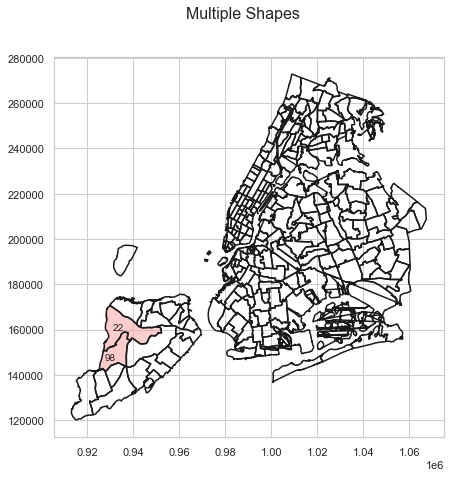

In [45]:
y_lim = None
x_lim = None

zone_id = [22, 98]
zones_map("Multiple Shapes", zone_id, df, x_lim=x_lim, y_lim=y_lim, color = 'r')

We can also plot only selected bondaries.

<Figure size 504x504 with 0 Axes>

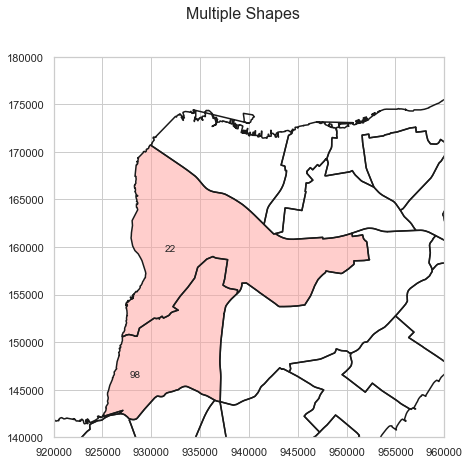

In [46]:
x_lim = (0.92e6, 0.96e6)
y_lim = (1.4e5, 1.8e5)

zone_id = [22, 98]
zones_map("Multiple Shapes", zone_id, df, x_lim=x_lim, y_lim=y_lim, color = 'r')

### Ploting a map for Borough

Above we were ploting maps for zones. Now we will plot maps for higher resolution, i.e. for boroughs.

In [49]:
borough_ids = {f'{borough}': list(df.loc[df.borough == borough].index) for borough in df['borough'].unique()}

In [50]:
df['borough'].unique()

array(['EWR', 'Queens', 'Bronx', 'Manhattan', 'Staten Island', 'Brooklyn'],
      dtype=object)

In [60]:
def borough_map(title, df, ax,
                x_lim = None, 
                y_lim = None, 
                show_labels=True,
                labels=None):
    '''
    Plot map with lim coordinates
    '''
    
    borough_ids = {f'{borough}': list(df.loc[df.borough == borough].index) for borough in df['borough'].unique()}
    borough_colors = {'EWR': 'green', 
                      'Queens': 'red', 
                      'Bronx': 'grey', 
                      'Manhattan': 'purple', 
                      'Staten Island': 'orange', 
                      'Brooklyn': 'blue'}
    
   
    for coord in df['coords']:
        x = [i[0] for i in coord]
        y = [i[1] for i in coord]
        ax.plot(x, y, 'k')
    
    for borough_name, zone_ids in borough_ids.items():
        coords = df.loc[df['borough'] == borough_name, 'coords']
        coords = list(itertools.chain.from_iterable(coords))
        
        for zone_id in zone_ids:
            coord = df.loc[zone_id, 'coords']
            x_lon = [i[0] for i in coord]
            y_lat = [i[1] for i in coord]
            ax.fill(x_lon,y_lat, borough_colors[borough_name], alpha=0.25)
            
        x0 = np.mean([c[0] for c in coords])
        y0 = np.mean([c[1] for c in coords])
        if show_labels:
            if labels is not None and labels.get(borough_name) is not None:
                text = borough_name + f'\n{labels.get(borough_name)}'
            else:
                text = borough_name
            ax.text(x0, y0, text, bbox=dict(facecolor='black', alpha=0.75), color="white", fontsize=15)
    
    if (x_lim != None) & (y_lim != None):     
        ax.xlim(x_lim)
        ax.ylim(y_lim)
        
    ax.set_title(title)

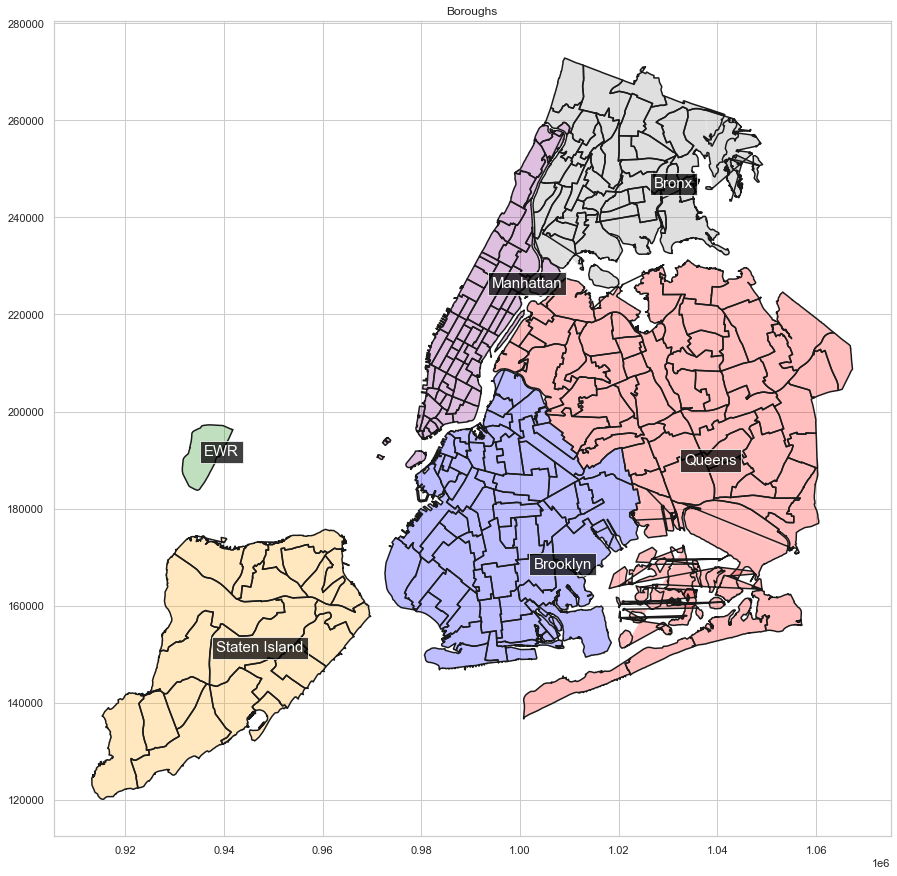

In [62]:
fig, ax = plt.subplots(1, figsize = (15, 15))
borough_map("Boroughs", df, ax)